In [79]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None

In [80]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submit = pd.read_csv('data/gender_submission.csv')

使用 info 來檢查有無空值，通常比賽能夠準確預測的關鍵都是在如何補空值。

發現train的Age,Cabin,Embark有空值；Test的Age, Fare, cabin有空值的情況

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


接下來由於要對整體資料做一些觀察，因此先將資料做合併

In [10]:
data = train.append(test)
data

C:\Users\Albert\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


直接append的話，index會是889,890,891,0,1,....

因此要重新設定index

In [11]:
data.reset_index(drop = True, inplace = True)   
#drop=True會將原本的index項捨棄，否則原本的index項會額外保留
#inplace = True會改變原本的data，否則原本的data不會被改變

# Data Analysis

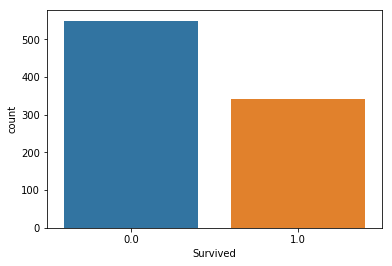

In [12]:
sns.countplot(data['Survived'])

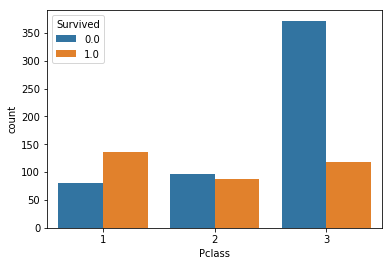

In [13]:
# 艙等與生存率
sns.countplot(data['Pclass'] , hue = data['Survived'])

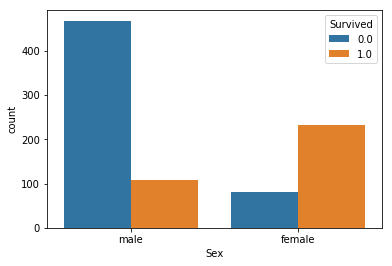

In [14]:
# 性別與生存率
sns.countplot(data['Sex'] , hue = data['Survived'])

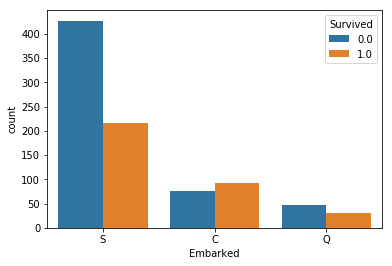

In [15]:
# 出發港口與生存率
sns.countplot(data['Embarked'] , hue = data['Survived'])

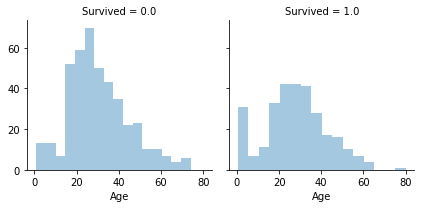

In [16]:
# 年齡與生存率
# Facetgrid : https://zhuanlan.zhihu.com/p/27816821
g = sns.FacetGrid(data , col='Survived')
g.map(sns.distplot ,'Age',kde=False)

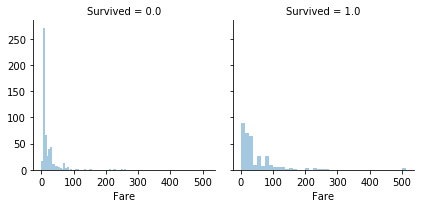

In [17]:
# 票價與生存率
g = sns.FacetGrid(data , col='Survived')
g.map(sns.distplot,'Fare',kde=False)

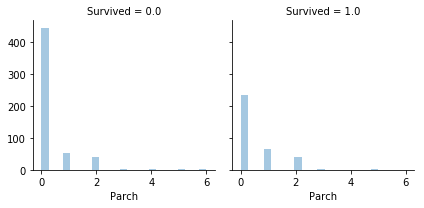

In [18]:
# 父母/小孩數量 與 生存率
g = sns.FacetGrid(data , col = 'Survived')
g.map(sns.distplot, 'Parch',kde = False)

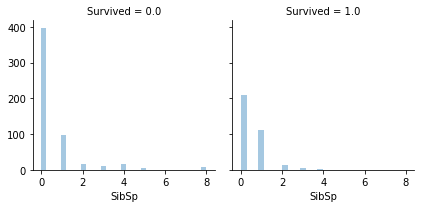

In [19]:
# 兄弟姊妹/夫妻 與 生存率
g = sns.FacetGrid(data , col = 'Survived')
g.map(sns.distplot , 'SibSp',kde = False)

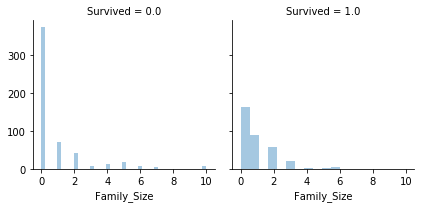

In [20]:
data['Family_Size'] = data['SibSp'] + data['Parch']
g = sns.FacetGrid(data , col = 'Survived')
g.map(sns.distplot , 'Family_Size',kde=False)

# 特徵工程

接下來要來處理之前提到一些特徵，像是姓名這個欄位的資料就不能直接拿來用，但如果直接丟掉是一種資訊的浪費，因此我們稍微觀察一下名字這個欄位，可以發現名字的這個欄位有稱謂的資訊(Mr., Miss.) 我們可以利用這些資訊在未來更加提升預測的準確度

In [21]:
# spilt: https://blog.csdn.net/qq_22238533/article/details/76187597
data['Title1'] = data['Name'].str.split(',' ,expand= True )[1]

In [22]:
data['Title1'].head()

0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
3             Mrs. Jacques Heath (Lily May Peel)
4                              Mr. William Henry
Name: Title1, dtype: object

In [23]:
data['Title1'] = data['Title1'].str.split('.',expand = True)[0]
data['Title1'].head()

0       Mr
1      Mrs
2     Miss
3      Mrs
4       Mr
Name: Title1, dtype: object

In [24]:
data['Title1'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

將稱謂對性別、生存率、以及年齡做分析

In [25]:
pd.crosstab(data['Sex'],data['Title1']).style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [26]:
pd.crosstab(data['Survived'],data['Title1']).style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0.0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1.0,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1


In [27]:
data.groupby(['Title1'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Title1,,,,,,,,
Capt,1.0,70.000000,NaN,70.00,70.00,70.0,70.00,70.0
Col,4.0,54.000000,5.477226,47.00,51.50,54.5,57.00,60.0
Don,1.0,40.000000,NaN,40.00,40.00,40.0,40.00,40.0
Dona,1.0,39.000000,NaN,39.00,39.00,39.0,39.00,39.0
Dr,7.0,43.571429,11.731115,23.00,38.00,49.0,51.50,54.0
Jonkheer,1.0,38.000000,NaN,38.00,38.00,38.0,38.00,38.0
Lady,1.0,48.000000,NaN,48.00,48.00,48.0,48.00,48.0
Major,2.0,48.500000,4.949747,45.00,46.75,48.5,50.25,52.0
Master,53.0,5.482642,4.161554,0.33,2.00,4.0,9.00,14.5


若仔細觀察這些稱謂(’Mr’, ‘Mrs’, ‘Miss’, ‘Master’, ‘Don’, ‘Rev’, ‘Dr’, ‘Mme’, ‘Ms’, ‘Major’, ‘Lady’, ‘Sir’, ‘Mlle’, ‘Col’, ‘Capt’, ‘the Countess’, ‘Jonkheer’, ‘Dona’)會發現有些是稱謂的乘客非常少，如果我們只為了這些少數的乘客多了一個稱謂這樣對於機器學習的模型來說是一件不好的事情。因此我們把其中的稱謂做合併。


In [28]:
#無效
data['Title2'] = data['Title1'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
    ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])

In [29]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

再來把票號的資訊取出前面英文的部分，因為相同的英文代碼可能代表的是房間的位置，後面的號碼沒有意義所以省略，如果只有號碼的票號就用X來表示

In [30]:
#apply and lambda : https://www.itread01.com/content/1548122409.html
# strip() : 預設為清除首尾空白
# isdigit() : 如果字符串只包含数字则返回 True 否则返回 False。
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".",'').replace("/","").strip().split(' ')[0] if not x.isdigit() else "X")

In [31]:
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

由於登船港口(Embarked)只有遺漏少數，我們就直接補上出現次數最多的”S”，費用(Fare)也只有遺漏一筆，因此就直接補上平均值

In [32]:
data['Embarked'] = data['Embarked'].fillna('S')
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())

觀察Cabin的資料後，只取出最前面的英文字母，剩下的用NoCabin來表示

In [33]:
data['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [34]:
#pd.isnull(x)會回傳 True 或 False
data['Cabin'] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else "NoCabin")

In [35]:
data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

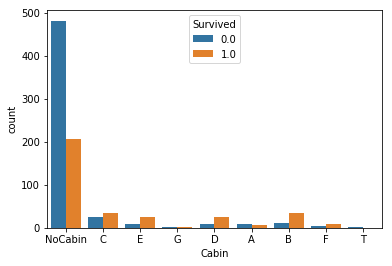

In [36]:
sns.countplot(data['Cabin'],hue=data['Survived'])

# 將類別資料轉為整數

In [37]:
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info
0,22.0,7,2,7.2500,"Braund, Mr. Owen Harris",0,1,2,1,1,0.0,A/5 21171,1,12,12,2
1,38.0,2,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,0,1,1.0,PC 17599,1,13,13,14
2,26.0,7,2,7.9250,"Heikkinen, Miss. Laina",0,3,2,0,0,1.0,STON/O2. 3101282,0,9,9,31
3,35.0,2,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,0,1,1.0,113803,1,13,13,36
4,35.0,7,2,8.0500,"Allen, Mr. William Henry",0,5,2,1,0,0.0,373450,0,12,12,36
5,NaN,7,1,8.4583,"Moran, Mr. James",0,6,2,1,0,0.0,330877,0,12,12,36
6,54.0,4,2,51.8625,"McCarthy, Mr. Timothy J",0,7,0,1,0,0.0,17463,0,12,12,36
7,2.0,7,2,21.0750,"Palsson, Master. Gosta Leonard",1,8,2,1,3,0.0,349909,4,8,8,36
8,27.0,7,2,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,2,0,0,1.0,347742,2,13,13,36
9,14.0,7,0,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,1,0,1,1.0,237736,1,13,13,36


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
Age            1046 non-null float64
Cabin          1309 non-null int8
Embarked       1309 non-null int8
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int8
Sex            1309 non-null int8
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Family_Size    1309 non-null int64
Title1         1309 non-null int8
Title2         1309 non-null int8
Ticket_info    1309 non-null int8
dtypes: float64(3), int64(4), int8(7), object(2)
memory usage: 101.1+ KB


除了Age，其他的空值都被處理好了

用隨機森林推測Age：

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info
0,41.340767,7,1,8.4583,"Moran, Mr. James",0,6,2,1,0,0.0,330877,0,12,12,36
1,41.630986,7,2,13.0000,"Williams, Mr. Charles Eugene",0,18,1,1,0,1.0,244373,0,12,12,36
2,46.792625,7,0,7.2250,"Masselmani, Mrs. Fatima",0,20,2,0,0,1.0,2649,0,13,13,36
3,41.340767,7,0,7.2250,"Emir, Mr. Farred Chehab",0,27,2,1,0,0.0,2631,0,12,12,36
4,34.860886,7,1,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,2,0,0,1.0,330959,0,9,9,36
5,39.443153,7,2,7.8958,"Todoroff, Mr. Lalio",0,30,2,1,0,0.0,349216,0,12,12,36
6,49.286267,1,0,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,32,0,0,1,1.0,PC 17569,1,13,13,14
7,34.860886,7,1,7.7500,"Glynn, Miss. Mary Agatha",0,33,2,0,0,1.0,335677,0,9,9,36
8,41.340767,7,0,7.2292,"Mamee, Mr. Hanna",0,37,2,1,0,1.0,2677,0,12,12,36
9,41.340767,7,0,7.8958,"Kraeff, Mr. Theodor",0,43,2,1,0,0.0,349253,0,12,12,36


In [41]:
dataAgeNull = data[data['Age'].isna()]
dataAgeNotNull = data[data['Age'].notna()]
#outlier : 與平均相差超過四個標準差即定義為outlier
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
                      (np.abs(dataAgeNotNull["Family_Size"]-dataAgeNotNull["Family_Size"].mean())>(4*dataAgeNotNull["Family_Size"].std()))                     
                     ]
rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Embarked','Fare','Pclass','Sex','Family_Size','Title1','Title2','Cabin','Ticket_info']
rfModel_age.fit(remove_outlier[ageColumns],remove_outlier['Age'])

ageNullValues = rfModel_age.predict(X = dataAgeNull[ageColumns])
dataAgeNull.loc[:,'Age'] = ageNullValues
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace = True,drop=True)

data.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info
0,41.340767,7,1,8.4583,"Moran, Mr. James",0,6,2,1,0,0.0,330877,0,12,12,36
1,41.630986,7,2,13.0000,"Williams, Mr. Charles Eugene",0,18,1,1,0,1.0,244373,0,12,12,36
2,46.792625,7,0,7.2250,"Masselmani, Mrs. Fatima",0,20,2,0,0,1.0,2649,0,13,13,36
3,41.340767,7,0,7.2250,"Emir, Mr. Farred Chehab",0,27,2,1,0,0.0,2631,0,12,12,36
4,34.860886,7,1,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,2,0,0,1.0,330959,0,9,9,36
5,39.443153,7,2,7.8958,"Todoroff, Mr. Lalio",0,30,2,1,0,0.0,349216,0,12,12,36
6,49.286267,1,0,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,32,0,0,1,1.0,PC 17569,1,13,13,14
7,34.860886,7,1,7.7500,"Glynn, Miss. Mary Agatha",0,33,2,0,0,1.0,335677,0,9,9,36
8,41.340767,7,0,7.2292,"Mamee, Mr. Hanna",0,37,2,1,0,1.0,2677,0,12,12,36
9,41.340767,7,0,7.8958,"Kraeff, Mr. Theodor",0,43,2,1,0,0.0,349253,0,12,12,36


In [48]:
dataTrain = data[pd.notna(data['Survived'])].sort_values(by = ['PassengerId'])
dataTest = data[~pd.notna(data['Survived'])].sort_values(by = ['PassengerId'])
# ~ 波浪號(tilde):https://www.runoob.com/python/python-operators.html，此處~ 跟 - 跟 isna功能相同

In [50]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 263 to 976
Data columns (total 16 columns):
Age            891 non-null float64
Cabin          891 non-null int8
Embarked       891 non-null int8
Fare           891 non-null float64
Name           891 non-null object
Parch          891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int8
Sex            891 non-null int8
SibSp          891 non-null int64
Survived       891 non-null float64
Ticket         891 non-null object
Family_Size    891 non-null int64
Title1         891 non-null int8
Title2         891 non-null int8
Ticket_info    891 non-null int8
dtypes: float64(3), int64(4), int8(7), object(2)
memory usage: 75.7+ KB


In [51]:
dataTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 977 to 262
Data columns (total 16 columns):
Age            418 non-null float64
Cabin          418 non-null int8
Embarked       418 non-null int8
Fare           418 non-null float64
Name           418 non-null object
Parch          418 non-null int64
PassengerId    418 non-null int64
Pclass         418 non-null int8
Sex            418 non-null int8
SibSp          418 non-null int64
Survived       0 non-null float64
Ticket         418 non-null object
Family_Size    418 non-null int64
Title1         418 non-null int8
Title2         418 non-null int8
Ticket_info    418 non-null int8
dtypes: float64(3), int64(4), int8(7), object(2)
memory usage: 35.5+ KB


In [54]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',  'Pclass', 'Sex', 'Family_Size', 'Title2','Ticket_info','Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Family_Size', 'Title2','Ticket_info','Cabin']]
dataTrain.head()

,Survived,Age,Embarked,Fare,Pclass,Sex,Family_Size,Title2,Ticket_info,Cabin
263,0.0,22.0,2,7.2500,2,1,1,12,2,7
264,1.0,38.0,0,71.2833,0,0,1,13,14,2
265,1.0,26.0,2,7.9250,2,0,0,9,31,7
266,1.0,35.0,2,53.1000,0,0,1,13,36,2
267,0.0,35.0,2,8.0500,2,1,0,12,36,7


In [55]:
dataTest.head()

,Age,Embarked,Fare,Pclass,Sex,Family_Size,Title2,Ticket_info,Cabin
977,34.5,1,7.8292,2,1,0,12,36,7
978,47.0,2,7.0000,2,0,1,13,36,7
979,62.0,1,9.6875,1,1,0,12,36,7
980,27.0,2,8.6625,2,1,0,12,36,7
981,22.0,2,12.2875,2,0,2,13,36,7


In [47]:
len(data[pd.isna(data['Survived'])])

418

In [63]:
rf = RandomForestClassifier(criterion = 'gini',
                            n_estimators= 1000,
                            min_samples_split = 12,
                            min_samples_leaf = 1,
                            oob_score=True,
                            random_state = 1,
                            n_jobs = -1                           
                           )
rf.fit(dataTrain.iloc[:,1:] , dataTrain.iloc[:,0])

#oob_score 與 oob_score_ 不同，後者顯示準確率，前者為bool
print('%.4f'%rf.oob_score_)
print('%.4f'%rf.oob_score)

0.8260
1.0000


In [70]:
pd.concat([pd.DataFrame(dataTrain.iloc[: , 1:].columns,columns = ['variable']) ,
           pd.DataFrame(rf.feature_importances_,columns = ['importance'])],
          axis=1).sort_values(by=['importance'],ascending = False)

,variable,importance
4,Sex,0.276262
2,Fare,0.165452
6,Title2,0.143690
0,Age,0.135462
3,Pclass,0.088227
5,Family_Size,0.069242
8,Cabin,0.064145
7,Ticket_info,0.031847
1,Embarked,0.025672


# Submit

In [75]:
rf_res = rf.predict(dataTest)
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit.csv',index = False)
submit.to_csv('TTT.csv',index = True)

In [76]:
submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
